<font size=4><b>Import necessary Libraries</b></font>

In [1]:
import pandas as pd
import numpy as np
import os
import random
import time
import csv
import matplotlib.pyplot
from matplotlib import pyplot as plt
import math
from sklearn.cluster import KMeans # Used for K-Means Clustering

<font size=4><b>List of Input CSV Source Files</b></font>

In [2]:
img_ids = os.listdir('./Inputs')
print(img_ids) #List of Input files

['.ipynb_checkpoints', 'GSC_CFeatures.csv', 'GSC_CTargets.csv', 'GSC_diffn_pairs.csv', 'GSC_features.csv', 'GSC_same_pairs.csv', 'GSC_SFeatures.csv', 'GSC_STargets.csv', 'HOF_diffn_pairs.csv', 'HOF_features.csv', 'HOF_same_pairs.csv', 'HO_CFeatures.csv', 'HO_CTargets.csv', 'HO_SFeatures.csv', 'HO_STargets.csv']


<font size=4><b>Human Observed Dataset Creation</b></font>

In [3]:
def create_HOF_dataset(same, diff, features):

    #p = 0.004300000 #0.0043% of lines will be read randomly in HOF Dataset
    p = 0.002800000 #0.0028% of lines will be read randomly in HOF Dataset
    df1 = pd.read_csv(same)
    df2 = pd.read_csv(diff, header=0, skiprows=lambda i: i>0 and random.random() > p)
    df3 = pd.concat([df1,df2]) #HOF Merged
    df = pd.read_csv(features) #Read HO Features
    df4 = df3.join(df.set_index('img_id'), on='img_id_A')
    df6 = df4.iloc[:,3:12].copy() #Stores a set of first image's features only
    
    df7 = df3.join(df.set_index('img_id'), on='img_id_B')
    df8 = df7.iloc[:,3:12].copy() #Stores a set of second image's features only
    
    df9 = df6.sub(df8, fill_value=0)
    df9 = df9.abs()
    df10 = pd.concat([df3, df9], axis=1) #df10 is the complete subtracted dataset
    df5 = df4.join(df.set_index('img_id'), on='img_id_B',lsuffix='_A', rsuffix='_B') #df5 is the complete concatenated dataset
    
    df5 = df5.sample(frac=1) #Shuffle Concatenated Dataset
    df10 = df10.sample(frac=1) #Shuffle Subtracted Dataset
    
    display(df5.head())
    print(df5.shape)
    display(df10.head())
    print(df10.shape)
    
    T_C = df5['target']
    T_S = df10['target']
    X_C = df5[df5.columns[3:21]]
    X_S = df10[df10.columns[3:12]]

    T_C.to_csv('./Inputs/HO_CTargets.csv', index=False, header=False)
    T_S.to_csv('./Inputs/HO_STargets.csv', index=False, header=False)
    X_C.to_csv('./Inputs/HO_CFeatures.csv', index=False, header=False)
    X_S.to_csv('./Inputs/HO_SFeatures.csv', index=False, header=False)

<font size=4><b>GSC Dataset Creation</b></font>

In [4]:
def create_GSC_dataset(same, diff, features):

    q = 0.09380394 #0.9380% of lines will be read randomly in GSC Dataset

    df1 = pd.read_csv(same)
    df2 = pd.read_csv(diff,header=0,skiprows=lambda i: i>0 and random.random() > q)
    df3 = pd.concat([df1,df2]) #GSC Merged
    df = pd.read_csv(features) #Read GSC Features
    
    df4 = df3.join(df.set_index('img_id'), on='img_id_A')
    df6 = df4.iloc[:,3:515].copy() #Stores a set of first image's features only
    
    df7 = df3.join(df.set_index('img_id'), on='img_id_B')
    df8 = df7.iloc[:,3:515].copy() #Stores a set of second image's features only
    
    df9 = df6.sub(df8, fill_value=0)
    df9 = df9.abs()
    df10 = pd.concat([df3, df9], axis=1) #df10 is the complete subtracted dataset
    #df10 = df10.loc[:, (df10 != 0).any(axis=0)] #Delete Zero Columns
    df5 = df4.join(df.set_index('img_id'), on='img_id_B',lsuffix='_A', rsuffix='_B') #df5 is the complete concatenated dataset
    #df5 = df5.loc[:, (df5 != 0).any(axis=0)] #Delete Zero Columns
    df5 = df5.sample(frac=1) #Shuffle Concatenated Dataset
    df10 = df10.sample(frac=1) #Shuffle Subtracted Dataset
    
    display(df5.head())
    print(df5.shape)
    display(df10.head())
    print(df10.shape)
    
    T_C = df5['target']
    T_S = df10['target']
    X_C = df5[df5.columns[3:1027]]
    X_S = df10[df10.columns[3:515]]

    T_C.to_csv('./Inputs/GSC_CTargets.csv', index=False, header=False)
    T_S.to_csv('./Inputs/GSC_STargets.csv', index=False, header=False)
    X_C.to_csv('./Inputs/GSC_CFeatures.csv', index=False, header=False)
    X_S.to_csv('./Inputs/GSC_SFeatures.csv', index=False, header=False)

### Partition Data, Get Design Matrix

In [5]:
def GetTargetVector(filePath):
    t = []
    with open(filePath, 'r') as f:
        reader = csv.reader(f) #Loads Expected Target values from target output file
        for row in reader:  
            t.append(int(row[0]))
    #print("Raw Training Generated..")
    #print(t)
    return t

def GenerateRawData(filePath):    
    dataMatrix = [] 
    with open(filePath, 'r') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column)) #Loads the rest of the training data
            dataMatrix.append(dataRow)   
    
    dataMatrix = np.transpose(dataMatrix)     
    #print ("Data Matrix Generated..")
    #print(datamatrix)
    return dataMatrix

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01))) #Selects 80% of targets for training
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent)) #Selects 80% of data for training
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

#Training targets and data generated

def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01)) #Selects 20% of data for validation
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

#Validation data generated

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01)) #Selects 20% of targets for validation
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

#Validation targets generated

def GenerateBigSigma(Data, MuMatrix,TrainingPercent): #Covariance Matrix
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct)) #Calculates variance between data features and stores in list 
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j] #Stores in diagonal positions only. Rest are assigned 0
    ##print ("BigSigma Generated..")
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L #For Computation of Phi this component is used

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x #Phi Computed for a vector

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI #Complete Phi Generated

def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y #Return Y output for Validation data

def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT)))) #Root Mean Square Accuracy and Error generated

### Functions for Logistic Regression

In [6]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [7]:
def cost(w, x, y):
    w = np.matrix(w)
    x = np.matrix(x)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(x * w.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(x * w.T)))
    return np.sum(first - second) / (len(x))

In [8]:
def gradient(w, x, y):
    w = np.matrix(w)
    x = np.matrix(x)
    y = np.matrix(y)
    
    par = int(w.ravel().shape[1]) #Number of features
    grad = np.zeros(par)
    
    error = sigmoid(x * w.T) - y.T #Calculate nx1 Error Matrix
    
    for i in range(0,par):
        term = np.multiply(error, x[:,i])
        grad[i] = np.sum(term)/len(x) #Return Average of n weights computed across all rows for one feature vector.
        
    return grad

<font size=4><b>Main Starts Here</b></font>

In [43]:
start_time = time.time()
create_HOF_dataset('./Inputs/HOF_same_pairs.csv', './Inputs/HOF_diffn_pairs.csv', './Inputs/HOF_features.csv')
#On every Run, the order of the rows in the Dataset is randomized (different). This causes a different split in data.
print("--- %s seconds ---" % (time.time() - start_time))

,img_id_A,img_id_B,target,f1_A,f2_A,f3_A,f4_A,f5_A,f6_A,f7_A,...,f9_A,f1_B,f2_B,f3_B,f4_B,f5_B,f6_B,f7_B,f8_B,f9_B
199,0414a,0414b,1,3,2,1,0,2,2,0,...,2,1,1,1,0,2,1,1,1,2
241,0458c,0458b,1,3,0,1,0,2,2,0,...,2,3,2,1,3,2,2,1,3,2
582,1360a,1360c,1,3,1,0,2,2,2,0,...,2,0,1,1,2,1,2,1,1,1
71,1432c,0404c,0,2,2,1,0,2,2,0,...,2,0,2,1,3,2,2,0,4,2
344,1090c,1335c,0,0,0,1,3,2,2,0,...,2,2,1,1,3,2,2,2,1,1


(1644, 21)


,img_id_A,img_id_B,target,f1,f2,f3,f4,f5,f6,f7,f8,f9
735,1358b,1152c,0,3,4,1,0,0,1,1,0,1
66,1518c,1518a,1,0,1,0,3,0,1,0,0,0
227,1424a,1554a,0,1,3,0,2,0,1,1,1,0
835,0585b,0540c,0,1,0,2,1,2,1,1,1,0
91,0571b,0571a,1,2,3,0,3,0,1,0,1,0


(1644, 12)
--- 0.6619856357574463 seconds ---


In [16]:
start_time = time.time()
create_GSC_dataset('./Inputs/GSC_same_pairs.csv', './Inputs/GSC_diffn_pairs.csv', './Inputs/GSC_features.csv')
#On every Run, the order of the rows in the Dataset is randomized (different). This causes a different split in data.
print("--- %s seconds ---" % (time.time() - start_time))

,img_id_A,img_id_B,target,f1_A,f2_A,f3_A,f4_A,f5_A,f6_A,f7_A,...,f503_B,f504_B,f505_B,f506_B,f507_B,f508_B,f509_B,f510_B,f511_B,f512_B
38019,0828b_num1.png,0828c_num2.png,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20954,0471b_num2.png,0471c_num1.png,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16598,0375c_num1.png,0375c_num3.png,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40160,0871b_num2.png,0871c_num3.png,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69867,1519b_num2.png,1519b_num5.png,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(142956, 1020)


,img_id_A,img_id_B,target,f1,f2,f3,f4,f5,f6,f7,...,f503,f504,f505,f506,f507,f508,f509,f510,f511,f512
59659,1301a_num1.png,1304c_num4.png,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
18744,0413a_num1.png,0418b_num3.png,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49513,1057aa_num2.png,1057cc_num1.png,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60839,1325a_num1.png,1346a_num1.png,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
26793,0590a_num1.png,0601a_num1.png,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


(142956, 512)


In [10]:
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 10 #Number of (Clusters OR anchor points OR Radio Basis functions)
PHI = [] #Stores design matrix. OR Matrix of all basis functions

### Fetch and Prepare Dataset

In [83]:
start_time = time.time()
#RawTarget = GetTargetVector('./Inputs/HO_CTargets.csv')
#RawData   = GenerateRawData('./Inputs/HO_CFeatures.csv')
#RawTarget = GetTargetVector('./Inputs/HO_STargets.csv')
#RawData   = GenerateRawData('./Inputs/HO_SFeatures.csv')
#RawTarget = GetTargetVector('./Inputs/GSC_CTargets.csv')
#RawData   = GenerateRawData('./Inputs/GSC_CFeatures.csv')
RawTarget = GetTargetVector('./Inputs/GSC_STargets.csv')
RawData   = GenerateRawData('./Inputs/GSC_SFeatures.csv')
#RawData = RawData[:, (RawData != 0).any(axis=0)] #Deletes columns all of which are 0.
RawData = RawData[~np.all(RawData == 0, axis=1)]  #Deletes rows all of which are 0.
print("--- %s seconds ---" % (time.time() - start_time))

--- 90.60344529151917 seconds ---


### Construct Training Data

In [84]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

(114339,)
(509, 114339)


### Construct Validation Data

In [85]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(14292,)
(509, 14292)


### Construct Test Data

In [86]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(TestDataAct.shape)
print(TestData.shape)

(14291,)
(509, 14291)


### Construct Design Matrix

In [68]:
start_time = time.time()
kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData)) #A very crucial step. Returns the entire training
#data divided into M clusters using K-Means Clustering Algorithm
Mu = kmeans.cluster_centers_ #Returns Centroids of M Clusters.

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100)
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1131.6092052459717 seconds ---


In [69]:
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

(10, 509)
(509, 509)
(114339, 10)
(14292, 10)
(14291, 10)


### Linear Regression using Gradient Descent Solution

In [70]:
start_time = time.time()
W_Now        = np.random.rand(M)
#W_Now        = np.zeros(M)
La           = 2
learningRate = 0.001
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
A_Val        = []
A_TR         = []
A_Test       = []

for i in range(0,len(TrainingData[0])):
#for i in range(0,1000):
    
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W) #Step by step updation of weights and Errors unlike Closed Form method.
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next

    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_Now) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    A_TR.append(float(Erms_TR.split(',')[0]))

    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_Now) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    A_Val.append(float(Erms_Val.split(',')[0]))

#-----------------TestingData Accuracy---------------------#
TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
Erms_Test = GetErms(TEST_OUT,TestDataAct)
L_Erms_Test.append(float(Erms_Test.split(',')[1]))
A_Test.append(float(Erms_Test.split(',')[0]))
print("--- %s seconds ---" % (time.time() - start_time))

--- 5.806060791015625 seconds ---


In [97]:
print ('UBITname      = animeshp')
print ('Person Number = 50290441')
print ('----------------------------------------------------')
print ('-Linear Regression Using Gradient Descent Solution--')
print ('----------------------------------------------------')
print ('----------------------------------------------------')
print ("M = "+str(M)+"\nLambda = "+str(La)+"\nLearning Rate = "+str(learningRate))
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))
print ("Accuracy Training   = " + str(np.around(max(A_TR),5))+"%")
print ("Accuracy Validation = " + str(np.around(max(A_Val),5))+"%")
print ("Accuracy Testing    = " + str(np.around(max(A_Test),5))+"%")

UBITname      = animeshp
Person Number = 50290441
----------------------------------------------------
-Linear Regression Using Gradient Descent Solution--
----------------------------------------------------
----------------------------------------------------
M = 10
Lambda = 2
Learning Rate = 0.001
E_rms Training   = 0.70761
E_rms Validation = 0.70537
E_rms Testing    = 0.70827
Accuracy Training   = 49.92872%
Accuracy Validation = 50.24489%
Accuracy Testing    = 49.83556%


### Logistic Regression using Gradient Descent Solution

In [72]:
#Initialize weight vector
W_Now = np.random.rand(TrainingData.shape[0])
start_time = time.time()
#W_Now = np.zeros(TrainingData.shape[0])
TrainAcc = []
ValAcc = []

learningRate = 0.001
la = 2

for i in range(0,len(TrainingData[0])):
#for i in range(0,500):
    #print("Loss for " +str(i)+ "epoch: " +str(cost(W_Now, TrainingData.T, TrainingTarget)))
    delta_W = gradient(W_Now, TrainingData.T, TrainingTarget)
    La_delta_W  = np.dot(la, W_Now)
    delta_W_Reg = np.add(delta_W, La_delta_W)
    W_Next = W_Now - (np.dot(learningRate, delta_W_Reg))
    W_Now = W_Next
    
    Y_Train_rounded = np.rint(sigmoid(np.matmul(TrainingData.T, W_Now)))
    diff = np.subtract(Y_Train_rounded, TrainingTarget)
    non_zeros = np.count_nonzero(diff)
    accuracy = ((len(diff) - non_zeros)/len(diff))*100
    TrainAcc.append(accuracy)

    Y_Val_rounded = np.rint(sigmoid(np.matmul(ValData.T, W_Now)))
    diff = np.subtract(Y_Val_rounded, ValDataAct)
    non_zeros = np.count_nonzero(diff)
    accuracy = ((len(diff) - non_zeros)/len(diff))*100
    ValAcc.append(accuracy)

Y_Test_rounded = np.rint(sigmoid(np.matmul(TestData.T, W_Now)))
diff = np.subtract(Y_Test_rounded, TestDataAct)
non_zeros = np.count_nonzero(diff)
test_accuracy = ((len(diff) - non_zeros)/len(diff))*100

print("--- %s seconds ---" % (time.time() - start_time))

--- 1309.7639381885529 seconds ---


In [96]:
print ('UBITname      = animeshp')
print ('Person Number = 50290441')
print ('----------------------------------------------------')
print ('Logistic Regression Using Gradient Descent Solution-')
print ('----------------------------------------------------')
print ('----------------------------------------------------')
print ("Regularizer = "+str(la)+"\nLearning Rate = "+str(learningRate))
print ("Training Accuracy = " + str(np.around(max(TrainAcc),5))+"%")
print ("Validation Accuracy = " + str(np.around(max(ValAcc),5))+"%")
print("Test Data Observation Below:")
print("Errors: " + str(non_zeros), " Correct :" + str(len(diff) - non_zeros))
print ("Testing Accuracy = "+str(np.around(test_accuracy, 5))+"%")

UBITname      = animeshp
Person Number = 50290441
----------------------------------------------------
Logistic Regression Using Gradient Descent Solution-
----------------------------------------------------
----------------------------------------------------
Regularizer = 2
Learning Rate = 0.001
Training Accuracy = 50.06866%
Validation Accuracy = 49.75511%
Test Data Observation Below:
Errors: 7123  Correct :7168
Testing Accuracy = 50.15744%


### Neural Network Model Definition

In [87]:
import keras
import keras.utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras import utils as np_utils
from keras import optimizers

input_size = TrainingData.shape[0]
drop_out = 0.2                                                                                                                                                                                                                                                                                                                                      
first_dense_layer_nodes  = 2048
second_dense_layer_nodes = 512
output_layer_nodes = 2

def get_model():
    
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size, activation='relu'))   
    model.add(Dropout(drop_out))
    
    model.add(Dense(second_dense_layer_nodes, activation='tanh'))
    model.add(Dropout(drop_out))
    
    model.add(Dense(output_layer_nodes, activation='sigmoid'))
    
    keras.optimizers.rmsprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    #sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    model.summary()
    
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [88]:
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2048)              1044480   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 1026      
Total params: 2,094,594
Trainable params: 2,094,594
Non-trainable params: 0
_________________________________________________________________


### Run Neural Network Model

In [89]:
validation_data_split = 0.20 # 20% of the training data is reserved as Validation Dataset. 
num_epochs = 10000 # One complete learning of the training data is called an Epoch. 
model_batch_size = 128 # Number of data samples in each batch
tb_batch_size = 32 
early_patience = 100 #Number of epochs with no improvement after which training is stopped. Here Gradient descent is used to 
# determine the point of local minima where the derivative of the plot equalls zero.  

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

concatenated_data = np.concatenate((TrainingData.T, ValData.T), axis=0)
concatenated_targets = np.concatenate((TrainingTarget.T, ValDataAct.T), axis=0)

concatenated_targets = np_utils.to_categorical(np.array(concatenated_targets),2)
# Process Dataset 
history = model.fit(concatenated_data
                    , concatenated_targets                         # Training occurs here
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb, earlystopping_cb]
                   )

Train on 102904 samples, validate on 25727 samples
Epoch 1/10000
102904/102904 [==============================] - 122s 1ms/step - loss: 0.5721 - acc: 0.7155 - val_loss: 0.5268 - val_acc: 0.7697
Epoch 2/10000
102904/102904 [==============================] - 126s 1ms/step - loss: 0.4106 - acc: 0.8185 - val_loss: 0.3860 - val_acc: 0.8319
Epoch 3/10000
102904/102904 [==============================] - 123s 1ms/step - loss: 0.3292 - acc: 0.8597 - val_loss: 0.3715 - val_acc: 0.8442
Epoch 4/10000
102904/102904 [==============================] - 144s 1ms/step - loss: 0.2458 - acc: 0.8999 - val_loss: 0.3554 - val_acc: 0.8491
Epoch 5/10000
102904/102904 [==============================] - 121s 1ms/step - loss: 0.1688 - acc: 0.9341 - val_loss: 0.4120 - val_acc: 0.8518
Epoch 6/10000
102904/102904 [==============================] - 122s 1ms/step - loss: 0.1118 - acc: 0.9599 - val_loss: 0.4246 - val_acc: 0.8602
Epoch 7/10000
102904/102904 [==============================] - 126s 1ms/step - loss: 0.0772

102904/102904 [==============================] - 137s 1ms/step - loss: 0.0010 - acc: 0.9999 - val_loss: 1.7481 - val_acc: 0.8527
Epoch 58/10000
102904/102904 [==============================] - 136s 1ms/step - loss: 0.0011 - acc: 0.9999 - val_loss: 1.7074 - val_acc: 0.8591
Epoch 59/10000
102904/102904 [==============================] - 136s 1ms/step - loss: 9.2968e-04 - acc: 0.9999 - val_loss: 1.7544 - val_acc: 0.8546
Epoch 60/10000
102904/102904 [==============================] - 136s 1ms/step - loss: 7.6253e-04 - acc: 0.9999 - val_loss: 1.7187 - val_acc: 0.8558
Epoch 61/10000
102904/102904 [==============================] - 137s 1ms/step - loss: 0.0016 - acc: 0.9998 - val_loss: 1.7398 - val_acc: 0.8587
Epoch 62/10000
102904/102904 [==============================] - 136s 1ms/step - loss: 0.0012 - acc: 0.9998 - val_loss: 1.7025 - val_acc: 0.8571
Epoch 63/10000
102904/102904 [==============================] - 138s 1ms/step - loss: 0.0012 - acc: 0.9998 - val_loss: 1.7440 - val_acc: 0.8584

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FF8AB64470>,
      dtype=object)

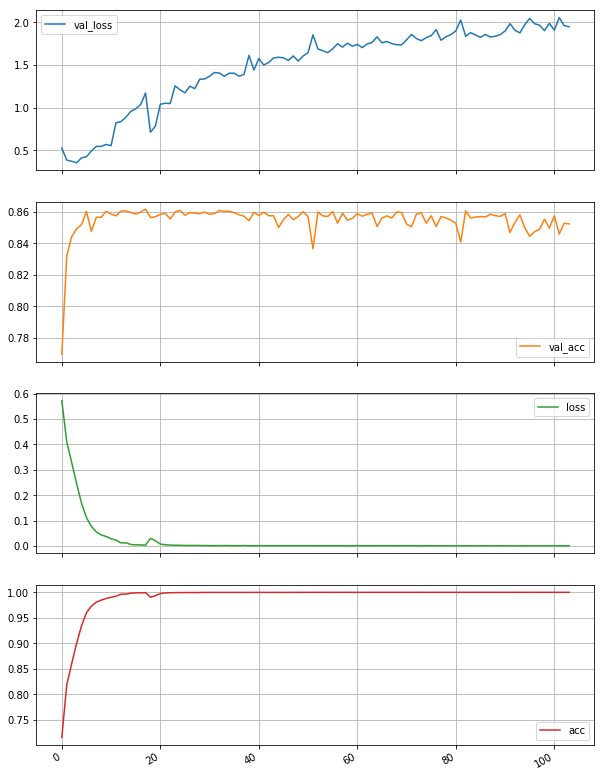

In [90]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [91]:
wrong   = 0
right   = 0

TestDataAct = np_utils.to_categorical(np.array(TestDataAct),2)
for i,j in zip(TestData.T,TestDataAct):
    y = model.predict(np.array(i).reshape(-1,TestData.shape[0])) # Here the model predicts classes of the test data.  
    if j.argmax() == y.argmax():
        right = right + 1 # Count Matches between predicted and processed values (Software 1.0 and 2.0) 
    else:
        wrong = wrong + 1 # Count Mismatches

print("Errors: " + str(wrong), " Correct :" + str(right))

print("Testing Accuracy: " + str(np.around(right/(right+wrong)*100, 5)))

Errors: 2076  Correct :12215
Testing Accuracy: 85.47337


Text(0.5,0,'Datasets on Linear Regression')

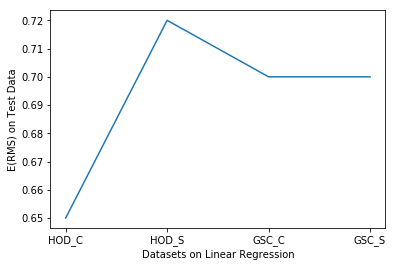

In [92]:
%matplotlib inline
l = [0.65, 0.72, 0.70, 0.70]
a = ['HOD_C','HOD_S','GSC_C','GSC_S']
plt.plot(a,l)
plt.ylabel('E(RMS) on Test Data')
plt.xlabel('Datasets on Linear Regression')

Text(0.5,0,'Datasets on Linear Regression')

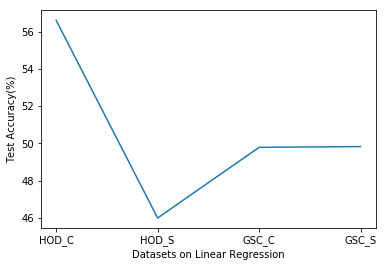

In [93]:
%matplotlib inline
l = [56.60, 46, 49.79, 49.83]
a = ['HOD_C','HOD_S','GSC_C','GSC_S']
plt.plot(a,l)
plt.ylabel('Test Accuracy(%)')
plt.xlabel('Datasets on Linear Regression')

Text(0.5,0,'Datasets on Logistic Regression')

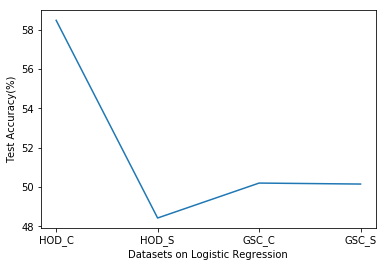

In [94]:
%matplotlib inline
l = [58.49, 48.42, 50.20, 50.15]
a = ['HOD_C','HOD_S','GSC_C','GSC_S']
plt.plot(a,l)
plt.ylabel('Test Accuracy(%)')
plt.xlabel('Datasets on Logistic Regression')

Text(0.5,0,'Datasets on Neural Networks')

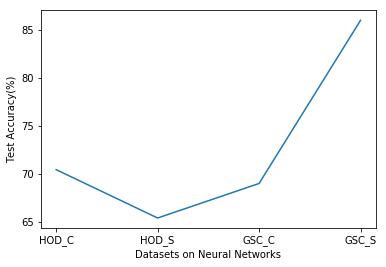

In [95]:
%matplotlib inline
l = [70.44, 65.40, 69, 86]
a = ['HOD_C','HOD_S','GSC_C','GSC_S']
plt.plot(a,l)
plt.ylabel('Test Accuracy(%)')
plt.xlabel('Datasets on Neural Networks')